In [1]:
#importing all the needed libraries
import pandas
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D,LeakyReLU

from keras.applications.vgg19 import VGG19

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
import math
import numpy as np
from keras import optimizers
from keras.applications import VGG19
from keras.utils import to_categorical
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
#setting the training and testing path
TRAIN_PATH=r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\TRAIN'
TEST_PATH=r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\VALIDATION'

In [72]:
#initialising the model
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(150,150,3))

In [41]:
#resizing the data and declaring the batch size
datagen = ImageDataGenerator(rescale=1. / 255)
batch_size=50

In [42]:
#loading the data from the directory
def get_data():
    X= datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(150, 150),
        batch_size=batch_size,classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL'],
        class_mode='categorical',
        shuffle=False)
    y= datagen.flow_from_directory(
        TEST_PATH,
        target_size=(150, 150),
        batch_size=batch_size,classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL'],
        class_mode='categorical',
        
        shuffle=False)

    return X,y

In [43]:
#getting the test and train data
X_train,y_test=get_data()

Found 14300 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [28]:
#Saving the training images with a prediction batch_size= total_samples/batch_Size

nb_train_samples = len(X_train.filenames) 
num_classes = len(X_train.class_indices)
#print(nb_train_samples,num_classes)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
#print(predict_size_train)
bottleneck_features_train = model.predict_generator(X_train,predict_size_train)
np.save(r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\bottleneck_features_train.npy', bottleneck_features_train)

In [149]:
#Saving the test images with a prediction batch_size= total_samples/batch_Size

nb_test_samples = len(y_test.filenames) 
num_classes = len(y_test.class_indices)
#print(nb_test_samples,num_classes)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))
bottleneck_features_test = model.predict_generator(y_test,predict_size_test)
np.save(r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\bottleneck_features_validation.npy', bottleneck_features_test)

71 4


In [44]:
#Loading both test and training dataset
train_data = np.load(r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\bottleneck_features_train.npy')
test_data = np.load(r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\bottleneck_features_validation.npy')

In [45]:
"""Counting different number of classes in the training set(this number will act as total number of nodes for the last layer 
in our VGG19 architecture), then converting the trianing and testing labels to categorical i.e. converting the input
vector which has integers representing various classes in the data to a matrix of binary values It has number of rows equal to 
the length of the input vector and number of columns equal to the number of classes."""

num_classes = len(X_train.class_indices) 
train_target = to_categorical(X_train.labels)
test_target=to_categorical(y_test.labels)

In [68]:
#Used tranfer learning(VGG19 network) and modified the last layer of the architecture to fit the model.
class Model:
    def __init__(self, classes, optimizer):
        self.classes = classes
        self.optimizer = optimizer
    def build_model(self):
        model=Sequential()
        #model.add(GlobalAveragePooling2D())
        model.add(Flatten(input_shape=train_data.shape[1:]))
        model.add(Dense(self.classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',optimizer=self.optimizer,metrics=['acc'])
        print(model.summary())
        return model
        

In [69]:
#created object of the class and got the build model
m=Model(num_classes,'adam')
model=m.build_model()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 32772     
Total params: 32,772
Trainable params: 32,772
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
#fit the training data and it's label to the model
history = model.fit(train_data,train_target,epochs=40,batch_size=batch_size)

Epoch 1/40
286/286 [==============================] - 1s 2ms/step - loss: 0.9724 - acc: 0.6137
Epoch 2/40
286/286 [==============================] - 1s 2ms/step - loss: 0.6344 - acc: 0.7858
Epoch 3/40
286/286 [==============================] - 1s 2ms/step - loss: 0.5221 - acc: 0.8241
Epoch 4/40
286/286 [==============================] - 1s 2ms/step - loss: 0.4378 - acc: 0.8614
Epoch 5/40
286/286 [==============================] - 1s 2ms/step - loss: 0.3796 - acc: 0.8826
Epoch 6/40
286/286 [==============================] - 1s 2ms/step - loss: 0.3415 - acc: 0.8972
Epoch 7/40
286/286 [==============================] - 1s 2ms/step - loss: 0.3026 - acc: 0.9118
Epoch 8/40
286/286 [==============================] - 1s 2ms/step - loss: 0.2798 - acc: 0.9201
Epoch 9/40
286/286 [==============================] - 1s 2ms/step - loss: 0.2619 - acc: 0.9229
Epoch 10/40
286/286 [==============================] - 1s 2ms/step - loss: 0.2386 - acc: 0.9348
Epoch 11/40
286/286 [============================

In [59]:
#save the best model
save_model_vgg2=model.save(r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\savemodelvgg19.h5')

In [89]:
#load the saved model
loadmodel=load_model(r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\savemodelvgg19.h5')

In [90]:
#function will return the test accuracy,when test label and data are given as input
def prediction():
    pred=loadmodel.evaluate(test_data,test_target,batch_size=50)
    return pred

In [91]:
#calling the prediction funciton
prediction()

2/2 [==============================] - 0s 498us/step - loss: 0.2786 - acc: 0.9155


[0.27862170338630676, 0.9154929518699646]

In [15]:
#modfying the prediciton in order to get the classification report and analysis how well the model is performing on test data
pred=np.round(loadmodel.predict(test_data),0)

In [16]:
#printing the classification report
cells=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
m=metrics.classification_report(test_target,pred,target_names=cells)
print(m)

              precision    recall  f1-score   support

  EOSINOPHIL       0.76      1.00      0.87        13
  LYMPHOCYTE       0.71      0.83      0.77         6
    MONOCYTE       1.00      1.00      1.00         4
  NEUTROPHIL       1.00      0.90      0.95        48

   micro avg       0.92      0.92      0.92        71
   macro avg       0.87      0.93      0.90        71
weighted avg       0.93      0.92      0.92        71
 samples avg       0.92      0.92      0.92        71



In [125]:
eos=lymph=mono=neutro=0

In [86]:
#getting prediction on a single image 
def single_pred(path):
    image=load_img(path,target_size=(150,150))
    image=img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image/=255
    classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
    bt_prediction = model.predict(image) 
    singlepred = loadmodel.predict_classes(bt_prediction)
    graph(classes[int(singlepred)])
    return classes[int(singlepred)]

In [77]:
#when input is multiple images return a graph indicating the total number of different types of WBc's found in the blood sample
eos=lymph=mono=neutro=0
def graph(type_cell):
    global eos,lymph,mono,neutro
    classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
    my_colors = ['r','g','b','c']
    #print(type_cell)
    for path in type_cell:
        #print(path)
        image=load_img(path,target_size=(150,150))
        image=img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image/=255.
        bt_prediction = model.predict(image) 
        singlepred = loadmodel.predict_classes(bt_prediction)
        #print(classes[int(singlepred)])
        if(classes[int(singlepred)]=='EOSINOPHIL'):
            eos=eos+1
        elif(classes[int(singlepred)]=='LYMPHOCYTE'):
            lymph=lymph+1
        elif(classes[int(singlepred)]=='MONOCYTE'):
            mono=mono+1
        else:
            neutro=neutro+1
    val=[eos,lymph,mono,neutro]
    bars=plt.bar(classes,val,color=my_colors,width=0.3)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+0.10, yval + .005, yval)
    
    plt.xlabel('Types of cell')
    plt.ylabel('Count')
    return plt.show()

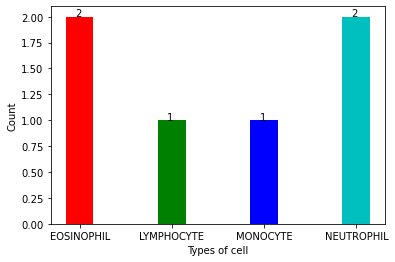

In [78]:
#input for the graph function is list of the paths of input images
cell_path=[r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\_16_6767.jpeg',r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\_0_771.jpeg',
          r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\_0_196.jpeg',
           r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\_0_1381.jpeg', r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\_0_1854.jpeg',
            r'C:\Users\nupur\Desktop\cells\dataset2-master\dataset2-master\images\_5_231.jpeg']
graph(cell_path)

In [84]:
classes=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

In [85]:
#confusion matrix to understand the performance of the classifcation model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [87]:
cf_matrix=confusion_matrix(test_target.argmax(axis=1),pred.argmax(axis=1))

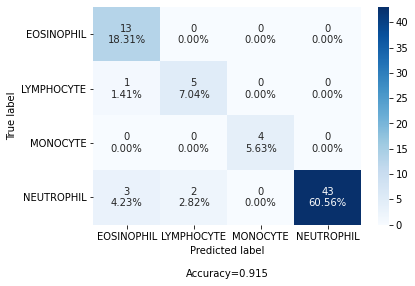

In [88]:
make_confusion_matrix(cf_matrix,categories=classes)